In [1]:
#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist
from scipy import signal

#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("darkgrid")
import figurefirst

#misc
import time
np.set_printoptions(suppress=True)

## Visualization

In [2]:
df1 = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/NotWindy_.h5')
# df2 = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/LowRes/NotWindy_ExpectedPP.h5')

In [3]:
df1

,master_time,xsrc,ysrc,odor,trisonica_u,trisonica_v,trisonica_pressure,trisonica_temperature,gps_linear_x,gps_linear_y,...,V,D,S2,corrected_u,corrected_v,time,nearest_from_streakline_,distance_from_source_,relative_parallel_comp,relative_perpendicular_comp
0,1.603220e+09,0.936368,-0.789034,0.673029,-1.298234,-0.661766,885.900024,7.394513,0.001117,0.033848,...,0.970000,148.000000,1.140000,-0.371148,1.077891,0.000000,6.219942,1.224483,0.000000,0.000000
1,1.603220e+09,0.936368,-0.789034,0.672028,-1.280317,-0.679683,885.900024,7.440302,0.002216,0.032424,...,0.968501,147.900096,1.140000,-0.373027,1.077242,0.004995,6.225759,1.224483,0.271658,-1.076408
2,1.603220e+09,0.936368,-0.789034,0.670134,-1.262399,-0.697601,885.900024,7.486091,0.003315,0.031000,...,0.967003,147.800192,1.140000,-0.374904,1.076590,0.009991,6.231576,1.224483,0.269619,-1.078710
3,1.603220e+09,0.936368,-0.789034,0.670388,-1.244482,-0.715518,885.900024,7.531879,0.004414,0.029577,...,0.965504,147.700288,1.140000,-0.376781,1.075935,0.014986,6.237394,1.224483,0.267578,-1.081008
4,1.603220e+09,0.936368,-0.789034,0.671013,-1.226617,-0.733359,885.900024,7.577590,0.005513,0.028153,...,0.964006,147.600383,1.140000,-0.378656,1.075276,0.019981,6.243211,1.224483,0.265537,-1.083302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241151,1.603229e+09,5.678414,2.594860,0.774349,2.429797,0.664057,883.599976,12.436637,-0.958139,-0.601554,...,1.669126,221.861306,2.241900,1.833339,1.290342,6199.978769,1.224483,6.243211,3.372161,-0.012230
1241152,1.603229e+09,5.673484,2.591651,0.774890,2.504782,0.525928,883.599976,12.414931,-0.961637,-0.608299,...,1.679618,221.811342,2.253391,1.841604,1.298563,6199.983765,1.224483,6.237394,3.390274,-0.018085
1241153,1.603229e+09,5.668555,2.588442,0.776000,2.579767,0.387799,883.599976,12.393225,-0.965134,-0.615044,...,1.690111,221.761378,2.264883,1.849857,1.306799,6199.988760,1.224483,6.231576,3.408384,-0.023960
1241154,1.603229e+09,5.663625,2.585233,0.775995,2.617107,0.300761,883.599976,12.380649,-0.968632,-0.621790,...,1.700603,221.711414,2.276375,1.858097,1.315050,6199.993755,1.224483,6.225759,3.426493,-0.029855


### Filter Design

In [4]:
# cf=1/(df1.master_time[1]-df1.master_time[0])
fs=200
nyq=fs*0.5
cutoff_freq=4

sos = signal.butter(2, cutoff_freq, 'low',fs=200, output='sos')
filtered = signal.sosfilt(sos, df1.odor)
# filtered = signal.lfilter(b, a, df1.odor)
df1['filtered_odor']=filtered

### Filtering Dataset

In [17]:
## Removing points near 2 meters
dt = df1.master_time[1]-df1.master_time[0]
df1.drop(df1[df1['distance_from_source'] < 2].index, inplace = True)

df1 = df1.drop(columns=['sync_time'])
sync_time = df1.master_time-df1.master_time[0]
df1['sync_time']=df.time

# dt = df1.master_time[1]-df1.master_time[0]
# df1 = df1.drop(columns=['filtered_odor'])
df1['filtered_odor']=filtered

## Removing points close to the source by 2 meters
# df1.drop(df1[df1['distance_from_source'] < 2].index, inplace = True)

#### Extracting Continuous Streakline

In [5]:
#pass time res and extract the continuous streakline

time_res=2002*5 ## 500 for lowres 
range_points = []
start_angle=df1.D[0]
range_points.append(0)
i = 0        
while i < (len(df1)):
    diff = np.abs(df1.D[i] - start_angle)
    if diff >= 60:
        range_points.append(i)
        start_angle=df1.D[i+time_res]
        i+=time_res
    else:
        i+=1
        continue

In [6]:
cs=pd.DataFrame()
j = 0
while j < (len(range_points)):
#     print(i)
    if(j < len(range_points)-1):
        cs = cs.append(df1[range_points[j]:range_points[j+1]])        
    else:
        cs = cs.append(df1[range_points[j]:])
    j+=2
cs.reset_index(inplace=True, drop=True) 


In [7]:
## removing the above 
# df1.drop(df1.loc[(df1['sync_time'] >= 1545) & (df1['sync_time'] <= 2290)].index,inplace=True) 
# df1 = df1.drop(columns=['sync_time'])

## count the new sync_time

time = []
time.append(0)
for i in range(1,len(cs)):
    time.append(time[i-1]+dt)

cs['time'] = time

cs.reset_index(inplace=True, drop=True) 

In [5]:
dir='~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/WindyFiltered4Hz.h5'
df1.to_hdf(dir, key='df1', mode='w')

#### Underlay Distance Plot with Encounter Plot

In [7]:
x = np.linspace(0,45,25)
y = np.linspace(0,35,10)
H1, x, y = np.histogram2d(df_occurence.distance_from_source, df_occurence.nearest_from_streakline, bins=(x, y), 
                          weights = df_occurence.odor)
N_Encounter = H1.T 
H2, x, y = np.histogram2d(df.distance_from_source, df.nearest_from_streakline, bins=(x, y), 
                          weights = df.odor)
Total = H2.T 

## removing areas less than 4000 deno

for i in range (len(Total)):
    for j in range(len(Total[i])):
        if Total[i][j]<2000:
            Total[i][j] =0
            N_Encounter[i][j]=0

Encounters = np.array(N_Encounter)/np.array(Total)
Encounters[Encounters == np.inf] = 0

<ipython-input-7-c4c290a24385>:18: RuntimeWarning: invalid value encountered in true_divide
  Encounters = np.array(N_Encounter)/np.array(Total)


In [5]:
query = 'odor>4'
df_occurence=pd.DataFrame()
df1=df1.query(query)

Text(0.5, 0.98, 'Wind Speed < 3m/s')

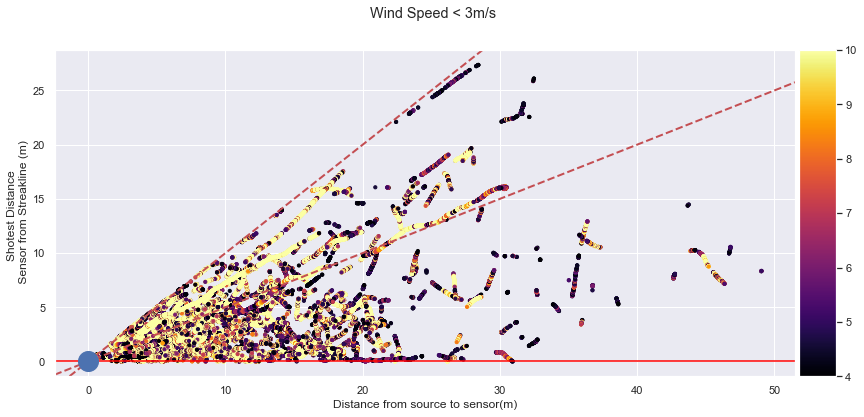

In [7]:
f, (ax1) = plt.subplots(1,1, figsize =(14,6))
ax1.axline((0, 0), slope=1.0, linestyle='dashed', linewidth=2, color='r')
ax1.axline((0, 0), slope=0.5, linestyle='dashed', linewidth=2, color='r')
ax1.axhline(0, color = 'red')
ax1.grid(True)
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df1.distance_from_source, df1.nearest_from_streakline_, cmap = 'inferno', 
                  c = df1.odor, label ='Odor_Not_Detected', vmin=4, vmax=10, s = 10)
# ax1.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'viridis', alpha= 0.5, 
#            extent=[x[0], x[-1], y[0], y[-1]])

ax1.set_xlabel('Distance from source to sensor(m)')
ax1.set_ylabel('Shotest Distance \n Sensor from Streakline (m)')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'vertical')
f.suptitle('Wind Speed < 3m/s')
# f.savefig('../../Figure/notwindydistplot.jpeg')

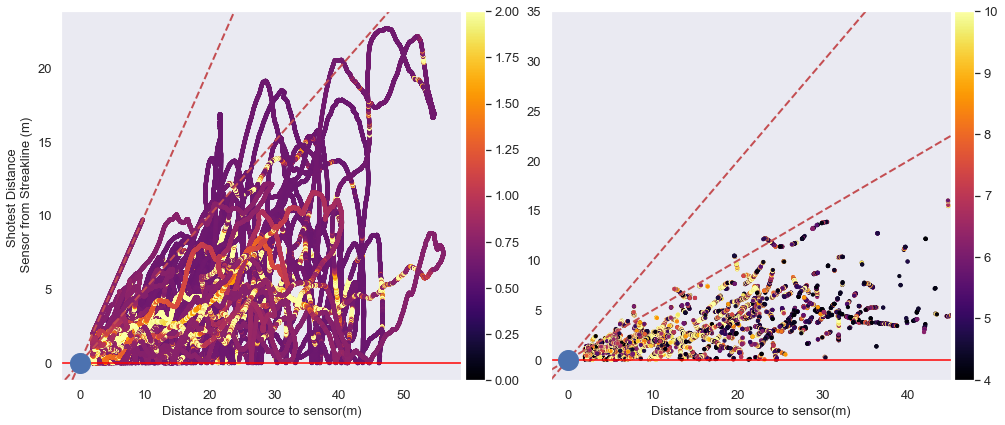

In [7]:
f, (ax1,ax2) = plt.subplots(1,2, figsize =(14,6))
ax1.axline((0, 0), slope=1.0, linestyle='dashed', linewidth=2, color='r')
ax1.axline((0, 0), slope=0.5, linestyle='dashed', linewidth=2, color='r')
ax1.axhline(0, color = 'red')
ax1.grid(False)
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df1.distance_from_source, df1.nearest_from_streakline, cmap = 'inferno', 
                  c = df1.odor, label ='Odor_Not_Detected', vmin=0, vmax=2, s = 10)
# ax1.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'viridis', alpha= 0.5, 
#            extent=[x[0], x[-1], y[0], y[-1]])

ax1.set_xlabel('Distance from source to sensor(m)')
ax1.set_ylabel('Shotest Distance \n Sensor from Streakline (m)')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'vertical')


ax2.axline((0, 0), slope=1.0, linestyle='dashed', linewidth=2, color='r')
ax2.axline((0, 0), slope=0.5, linestyle='dashed', linewidth=2, color='r')
ax2.axhline(0, color = 'red')
ax2.grid(False)
ax2.plot(0,0,'o', markersize = 20)

var2 = ax2.scatter(df_occurence.distance_from_source, df_occurence.nearest_from_streakline, cmap = 'inferno', 
                  c = df_occurence.odor, vmin=4, vmax=10, s = 10)

ax2.set_xlabel('Distance from source to sensor(m)')
# ax2.set_ylabel('Shotest Distance \n Sensor from Streakline (m)')
ax2.set_xlim ([-2,45])
ax2.set_ylim([-2,35])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 13)
# f.savefig('../../Figure/locationalrepOdor.jpeg')

## Find if there was direction change back in time for the above extracted points

In [4]:
df_occurence.insert(26,"slope",(df_occurence.nearest_from_streakline/df_occurence.distance_from_source))

In [11]:
q1 = 'slope>=0 & slope<0.08'
q2 = 'slope>=0.08 & slope<0.17'
q3 = 'slope>=0.17 & slope<0.27'
q4 = 'slope>=0.27 & slope<0.36'
q5 = 'slope>=0.36 & slope<0.46'
q6 = 'slope>=0.46 & slope<0.58'
q7 = 'slope>=0.58 & slope<0.7'
q8 = 'slope>=0.70 & slope<0.84'
q9 = 'slope>=0.84'

time_since_last_change_5 = []
time_since_last_change_10 = []
time_since_last_change_15 = []
time_since_last_change_20 = []
time_since_last_change_25 = []
time_since_last_change_30 = []
time_since_last_change_35 = []
time_since_last_change_40 = []
time_since_last_change_45 = []

In [28]:
df1=pd.DataFrame()
df1=df_occurence.query(q9)

In [29]:
# 100 rows approx 10 seconds for low res
# 2002 rows approx 10 seconds for hi res
lookback_time = 2002 * 5
check_angle = 90
for i in range(0,len(df1.index)): 
    angle = np.abs(df.D[(df1.index[i]-lookback_time):df1.index[i]] 
                   - df.D[df1.index[i]])
    
    if (angle>check_angle).any() == True: 
        pos = np.where(angle >= check_angle)
        time_since_last_change_45.append((lookback_time-pos[-1][-1])/0.005) ## because each row is 1/10 seconds
        
    else:
        continue

In [30]:
df_time=pd.DataFrame()
df_time_1=pd.DataFrame()
df_time_2=pd.DataFrame()
df_time_3=pd.DataFrame()
df_time_4=pd.DataFrame()
df_time_5=pd.DataFrame()
df_time_6=pd.DataFrame()
df_time_7=pd.DataFrame()
df_time_8=pd.DataFrame()
df_time_9=pd.DataFrame()

df_time_1['duration'] = time_since_last_change_5
df_time_1['angle']=np.repeat('0-0.08°',len(time_since_last_change_5))

df_time_2['duration'] = time_since_last_change_10
df_time_2['angle']=np.repeat('0.08-0.17',len(time_since_last_change_10))

df_time_3['duration'] = time_since_last_change_15
df_time_3['angle']=np.repeat('0.17-0.27',len(time_since_last_change_15))

df_time_4['duration'] = time_since_last_change_20
df_time_4['angle']=np.repeat('0.27-0.36',len(time_since_last_change_20))

df_time_5['duration'] = time_since_last_change_25
df_time_5['angle']=np.repeat('0.36-0.46',len(time_since_last_change_25))

df_time_6['duration'] = time_since_last_change_30
df_time_6['angle']=np.repeat('0.46-0.58',len(time_since_last_change_30))

df_time_7['duration'] = time_since_last_change_35
df_time_7['angle']=np.repeat('0.58-0.7',len(time_since_last_change_35))

df_time_8['duration'] = time_since_last_change_40
df_time_8['angle']=np.repeat('0.70-0.84',len(time_since_last_change_40))

df_time_9['duration'] = time_since_last_change_45
df_time_9['angle']=np.repeat('> 0.84',len(time_since_last_change_45))

df_time=pd.concat([df_time_1,df_time_2, df_time_3, df_time_4, df_time_5, df_time_6, df_time_7, df_time_8, df_time_9],
                  ignore_index=True)

In [31]:
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
# df_time.to_hdf(dir+'AngleDuration0102.h5', key='df_time', mode='w')

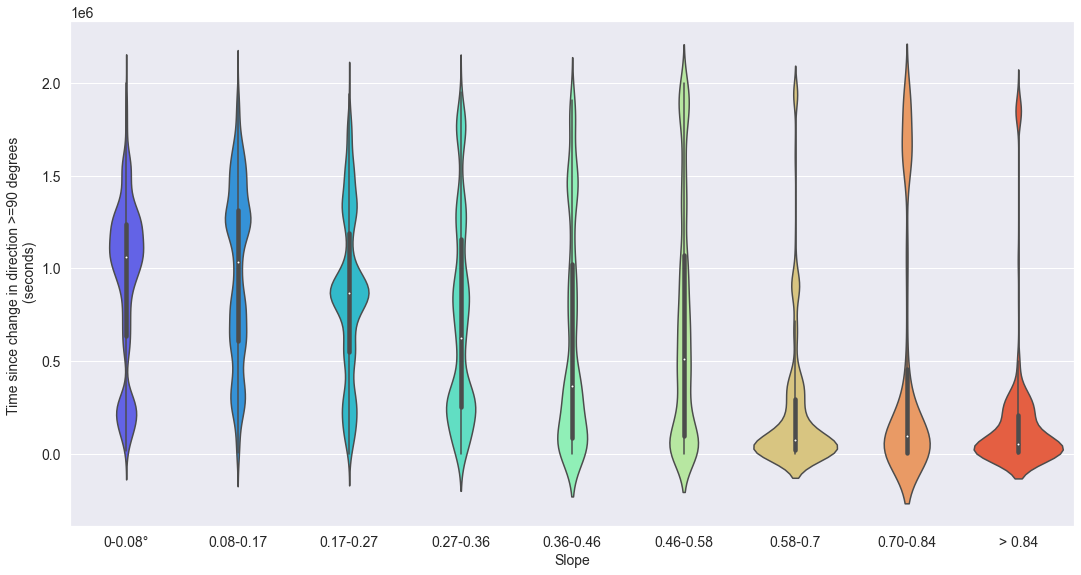

In [32]:
f, ax = plt.subplots(1,1, figsize=(15,8))
sns.violinplot(x='angle',y="duration", data=df_time, dodge='True', palette='rainbow')
# sns.boxplot(x="angle", y="duration", data=df_time,  dodge=True,  palette='viridis' )
# sns.catplot(x="angle", y="duration", data=df_time,  dodge=True,  palette='husl')
# sns.stripplot(x='angle', y='duration', data=df_time, dodge='True')

ax.set_xlabel('Slope')
ax.set_ylabel('Time since change in direction >=90 degrees \n (seconds)')
f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 14)
# f.savefig('../../Figure/timesincedirectionchange90HD.jpeg')

#### Find if there was a change in angle - output 0s and 1s

In [109]:
queryx='slope>0.57'
df2=pd.DataFrame()
df2 = df_occurence.query(queryx)

### BootStrap for Probability Significance

In [105]:
df_bootstrap_slopeless = pd.DataFrame()
df_bootstrap_slopemore = pd.DataFrame()
df_bootstrap=pd.DataFrame()

In [106]:
def prob_counter(index):
    for i in range(len(index)):
        if(index[i]<501):
            continue
        else:
            angle = np.abs(df.D[(index[i]-lookback_time):index[i]] - df.D[index[i]])
            if (angle>90).any() == True: 
                angle_changes_1.append(1)

            else: angle_changes_1.append(0)
            
    prob_yes.append(angle_changes_1.count(1)/(angle_changes_1.count(0)+angle_changes_1.count(1)))
    prob_no.append(angle_changes_1.count(0)/(angle_changes_1.count(0)+angle_changes_1.count(1)))
    

In [110]:
prob_yes=[]
prob_no=[]
angle_changes_1 = []
bootstrap_samples = 100
number_of_time = 500
lookback_time = 100*5
for i in range(number_of_time):
    index = np.random.choice(df2.index, size = bootstrap_samples)
    prob_counter(index)

In [48]:
# angle_changes_1 = []
# # 100 rows approx 10 seconds for low res
# # 2002 rows approx 10 seconds for hi res
# lookback_time = 100 * 5
# for i in range(0,len(df2.index)):
#     angle = np.abs(df.D[(df2.index[i]-lookback_time):df2.index[i]] - df.D[df2.index[i]])
#     if (angle>90).any() == True: angle_changes_1.append(1)
#     else: angle_changes_1.append(0)

In [111]:
df_bootstrap_slopemore['prob_of_direction_change'] = prob_yes
df_bootstrap_slopemore['slope']=np.repeat('slope>0.57',len(prob_yes))

In [108]:
df_bootstrap_slopeless['prob_of_direction_change'] = prob_yes
df_bootstrap_slopeless['slope']=np.repeat('slope<0.57',len(prob_yes))

In [112]:
df_bootstrap=pd.concat([df_bootstrap_slopemore,df_bootstrap_slopeless],
                  ignore_index=True)

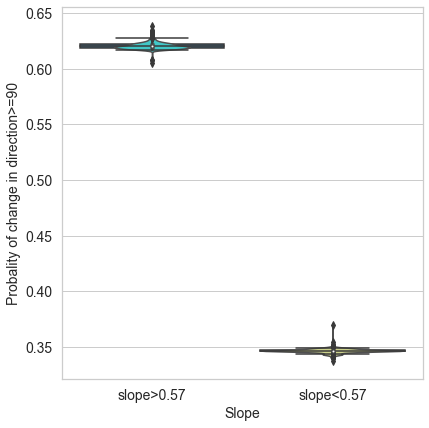

In [118]:
f, ax = plt.subplots(1,1, figsize=(6,6))
sns.violinplot(x="slope", y="prob_of_direction_change", data=df_bootstrap, dodge='True', palette='rainbow')
sns.boxplot(x="slope", y="prob_of_direction_change", data=df_bootstrap,  dodge=True,  palette='viridis' )
# sns.catplot(x="slope", y="prob_of_direction_change", data=df_bootstrap, dodge=True,  palette='husl')
# sns.stripplot(x="slope", y="prob_of_direction_change", data=df_bootstrap, dodge='True')
ax.set_xlabel('Slope')
ax.set_ylabel('Probality of change in direction>=90')
f.tight_layout()

figurefirst.mpl_functions.set_fontsize(f, 14)
f.savefig('../../Figure/probchangedirection.jpeg')

### Summary Plot

In [3]:
# f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize =(15,15) , gridspec_kw={'height_ratios': [8,3,3,3]})

# #plot wind vs odor from source and each other
# f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# # ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
# ax1.axhline(0, color = 'red')
# ax1.plot(0,0,'o', markersize = 20)
# # area = df.radius**2*0.4*m.pi #area
# # ax1.scatter(area[0:30]**2,df.mock[0:30])
# # ax1.scatter(df.sync_time[::300], df.mock[::300],  facecolors='none', edgecolors='b', s = area[::300])
# var = ax1.scatter(df.distance_along_streakline, df.nearest_particle, cmap = 'BuPu', c = df.odor,  s = 10)
# ax1.set_xlabel('Distance - Sensor to Source (meters)' , fontsize = 15)
# ax1.set_ylabel('Distance - Sensor to Streakline (meter)' , fontsize = 15)
# # ax1.xaxis.set_ticks(np.linspace(0, 30, 31).astype(int))
# # ax1.yaxis.set_ticks(np.linspace(0, 35, 10).astype(int))
# ax1.grid()

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('top', size='5%', pad=0.05)
# f.colorbar(var, cax=cax, orientation = 'horizontal')

# #plot concentration
# ax2.plot(df.sync_time,df.odor,color='Purple' , label="Encountered Odor")
# ax2.fill_between(df.sync_time, df.odor.min(), 11, where=df.odor_expected>0 ,facecolor='C1', alpha=1, label="Expected Odor")
# # ax2.plot(df.sync_time, df.odor_expected, label="Expected Odor")
# ax2.set_xlabel('Time (seconds)' , fontsize = 15)
# ax2.set_ylabel('Odor \n Comparison' , fontsize = 15)
# # ax2.set_facecolor('black')

# lgd=ax2.legend(loc='upper right',fancybox=True, shadow=True)

# ## plot direction
# ax3.plot(df.sync_time,df.D, color = 'green', label="Wind Direction")
# # ax3.plot(df.sync_time,sensor_direction, color = 'purple', label="Sensor Direction")
# ax3.set_xlabel('Time (seconds)' , fontsize = 15)
# ax3.set_ylabel('Direction (degrees)' , fontsize = 15)
# # ax3.axhline(150, color = 'red')
# lgd=ax3.legend(loc='upper right',fancybox=True, shadow=True)



# ## plot speed
# ax4.plot(df.sync_time,df.S2, color = 'green', label="Wind Speed")
# ax4.set_xlabel('Time (seconds)' , fontsize = 15)
# ax4.set_ylabel('Wind Speed (m/s)' , fontsize = 15)
# lgd=ax4.legend(loc='upper right',fancybox=True, shadow=True)
# # ax4.axhline(1.0, color = 'red')

# f.tight_layout()

# # f.savefig(dir_save+'Run0'+str(run)+'_plot_summary.jpeg')